## EMERGENCY vs NON-EMERGENCY - MODIFIED VERSION

    1) In this practical session we will be combining following techniques learnt so far and observe the performance.

      - Early Stopping. 
      
      - Dropout Regularization.
      
      - Batch Normalization.
      
      - Image Augmentation.

    2) We are not using CNN (Convolution Neural Network) technique.

### `STEP 1: IMPORT LIBRARIES`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage

from skimage.io import imshow, imread

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### `STEP 2: IMPORT DATASET`

In [2]:
import os 
os.getcwd()

'C:\\Users\\Gaurav Rajpal\\OneDrive\\Desktop\\Analytics Vidhya\\Course 3 - Fundamentals DL\\3 - Solving Image Classification using Keras\\NN_Project\\Improving Deep Learning Model'

In [3]:
data = pd.read_csv('../Dataset/emergency_classification.csv')
print("Data Imported Successfully")

Data Imported Successfully


### `STEP 3: EXPLORING DATASET`

In [4]:
# Checking top records

data.head(3)

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1


In [5]:
# Checking target column distribution

data.emergency_or_not.value_counts()

0    1361
1     991
Name: emergency_or_not, dtype: int64

In [6]:
# Loading image dataset and storing it in numpy array 

X = []

for image_name in data.image_names:
    img = imread('../Dataset/images/' + image_name)
    img = img/255
    X.append(img)
    
X = np.array(X)

y = data.emergency_or_not.values

In [7]:
# Shape of original data 

X.shape, y.shape

((2352, 224, 224, 3), (2352,))

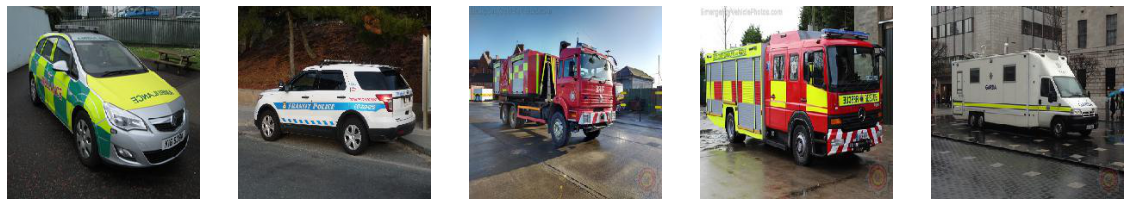

In [8]:
# Viewing the images 

fig,ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20, 20))

for i in range(0,5):
    ax[i].imshow(X[i])
    ax[i].axis('off')

<br>

### `STEP 4: BUILD MODEL`

In [9]:
# Printing Keras and Tensorflow version 

import keras
import tensorflow

print("Keras version      : {}".format(keras.__version__))
print("Tensorflow version : {}".format(tensorflow.__version__))

Keras version      : 2.4.3
Tensorflow version : 2.3.1


#### `STEPS FOR BUILDING NEURAL NETWORK`

    - 1. Loading the data
    
    - 2. Creating train / validation / test data.
    
    - 3. Data augmentation
    
    - 4. Defining model architecture.
    
          4.1. Add dropout layers
          
          4.2. Add Batch Normalization.
     
     - 5. Compiling the model
          
     - 6. Define early stopping & model checkpointing  
     
     - 7. Train the model using early stopping & model checkpointing
     
     - 8. Evaluate model performance.
     
     - 9. Hyperparameter tuning if possible.

> **`STEP 1 - LOADING DATA`**

    - We have alread teh data and preprocessed it. We will proceed with further steps.

> **`STEP 2 - CREATING TRAINING / VALIDATION / TEST DATA`**

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 42)

In [11]:
X_train.shape, X_test.shape, x_train.shape

((2116, 224, 224, 3), (236, 224, 224, 3), (1692, 224, 224, 3))

> **`STEP 3 - DATA AUGMENTATION`**

In [12]:
print("Shape of training dataset before : {}".format(x_train.shape))

Shape of training dataset before : (1692, 224, 224, 3)


In [13]:
from tqdm import tqdm                                # To show percentage of completion.

# Libraries for performing image augmentation tasks
from skimage.transform import rotate                  # Rotation
from skimage.util import random_noise                 # Noising
from skimage.filters import gaussian                  # Bluring 

In [14]:
# Augmenting the training images
final_train_data   = []
final_target_train = []

for i in tqdm(range(x_train.shape[0])):
    # original image
    final_train_data.append(x_train[i])
    
    # image rotation
    final_train_data.append(rotate(x_train[i], angle=30, mode = 'edge'))
    
    # image flipping (left-to-right)    
    final_train_data.append(np.fliplr(x_train[i]))
    
    # image flipping (up-down) 
    final_train_data.append(np.flipud(x_train[i]))
    
    # image noising
    final_train_data.append(random_noise(x_train[i],var=0.2))
    
    # image bluring 
    final_train_data.append(gaussian(x_train[i],sigma=2.5,multichannel=True))
    
    for j in range(6):
        final_target_train.append(y_train[i])

100%|██████████| 1692/1692 [01:15<00:00, 22.32it/s]


In [15]:
# Converting images and target to array
final_train        = np.array(final_train_data)
final_target_train = np.array(final_target_train)

In [16]:
# Shape of new training set
final_train.shape, final_target_train.shape 

((10152, 224, 224, 3), (10152,))

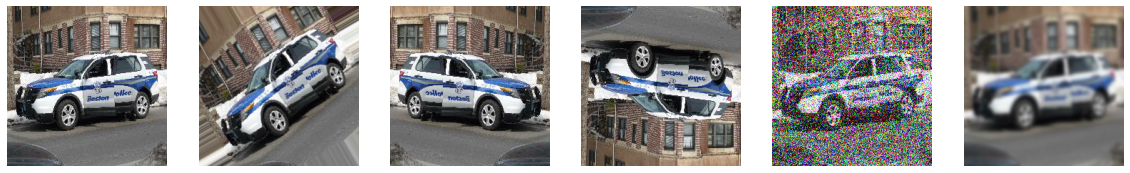

In [17]:
fig,ax = plt.subplots(nrows=1,ncols=6,figsize=(20,20))
for i in range(6):
    ax[i].imshow(final_train[i])
    ax[i].axis('off')

In [18]:
# Converting 3 dimensional image to 1 dimensional image

final_train = final_train.reshape(final_train.shape[0], 224*224*3)
final_train.shape

(10152, 150528)

In [19]:
# Minimum and Maximum pixel values of training images

final_train.min(), final_train.max()

(0.0, 1.0)

In [20]:
# Converting 3 dimensional validation image to 1 dimensional image

final_valid = x_val.reshape(x_val.shape[0], 224*224*3)
final_valid.shape

(424, 150528)

In [21]:
# Minimum and Maximum pixel values of validation images

final_valid.min(), final_valid.max()

(0.0, 1.0)

#### `STEP 4: DEFINING MODEL ARCHITECTURE`

In [22]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout, BatchNormalization

# Creating Skeleton
model = Sequential()

# Adding Input Layer
model.add(InputLayer(input_shape=(224*224*3,)))

# Adding Hidden Layers
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(25, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(12, activation= 'relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(6, activation= 'relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

# Adding Output Layer
model.add(Dense(units=1, activation='sigmoid'))

#### `STEP 5: COMPILING THE MODEL`

In [23]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#### `STEP 6: DEFINING EARLY STOPPING & MODEL CHECKPOINTING`

In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# defining the path to store the weights.
filepath="best_weights.hdf5"

# defining the model checkpointing and early stopping
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 20)

# defining checkpointing variable
callbacks_list = [checkpoint, early_stopping]
#callbacks_list = [checkpoint]

#### `STEP 7: TRAINING USING EARLINING STOPPING`

In [25]:
model_history = model.fit(final_train, final_target_train, validation_data=(final_valid, y_val), epochs = 1000, batch_size = 128, callbacks = callbacks_list)

Epoch 1/1000
80/80 [==============================] - ETA: 0s - loss: 0.8890 - accuracy: 0.5104
Epoch 00001: val_accuracy improved from -inf to 0.54009, saving model to best_weights.hdf5
80/80 [==============================] - 17s 210ms/step - loss: 0.8890 - accuracy: 0.5104 - val_loss: 0.7326 - val_accuracy: 0.5401
Epoch 2/1000
80/80 [==============================] - ETA: 0s - loss: 0.8155 - accuracy: 0.5276
Epoch 00002: val_accuracy improved from 0.54009 to 0.58962, saving model to best_weights.hdf5
80/80 [==============================] - 13s 165ms/step - loss: 0.8155 - accuracy: 0.5276 - val_loss: 0.6724 - val_accuracy: 0.5896
Epoch 3/1000
80/80 [==============================] - ETA: 0s - loss: 0.7690 - accuracy: 0.5384
Epoch 00003: val_accuracy improved from 0.58962 to 0.59670, saving model to best_weights.hdf5
80/80 [==============================] - 13s 167ms/step - loss: 0.7690 - accuracy: 0.5384 - val_loss: 0.6676 - val_accuracy: 0.5967
Epoch 4/1000
80/80 [=================

Epoch 29/1000
80/80 [==============================] - ETA: 0s - loss: 0.5694 - accuracy: 0.7241
Epoch 00029: val_accuracy did not improve from 0.69575
80/80 [==============================] - 12s 154ms/step - loss: 0.5694 - accuracy: 0.7241 - val_loss: 0.6231 - val_accuracy: 0.6651
Epoch 30/1000
80/80 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7306
Epoch 00030: val_accuracy did not improve from 0.69575
80/80 [==============================] - 11s 133ms/step - loss: 0.5603 - accuracy: 0.7306 - val_loss: 0.7317 - val_accuracy: 0.6108
Epoch 31/1000
80/80 [==============================] - ETA: 0s - loss: 0.5500 - accuracy: 0.7401
Epoch 00031: val_accuracy did not improve from 0.69575
80/80 [==============================] - 10s 127ms/step - loss: 0.5500 - accuracy: 0.7401 - val_loss: 0.7057 - val_accuracy: 0.6274
Epoch 32/1000
80/80 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.7482
Epoch 00032: val_accuracy did not improve from 0.69

#### `STEP 8: EVALUATING MODELS PERFORMANCE`

In [26]:
# Checking shape of test data.

X_test.shape

(236, 224, 224, 3)

In [27]:
# Converting 3D to 1D image 

X_test = X_test.reshape(X_test.shape[0], (224*224*3))

In [29]:
# Predicting on test data 

predict = model.predict_classes(X_test)

In [30]:
# Getting accuracy score - Test Data 

from sklearn.metrics import accuracy_score
print("Accuracy_Score : {}".format(accuracy_score(predict, y_test) * 100))

Accuracy_Score : 71.61016949152543


In [31]:
from sklearn.metrics import classification_report
print("\t\t\tCLASSIFICATION REPORT:\n")
print(classification_report(y_test, predict),'\n')

print("\t\t\tCONFUSION MATRIX:\n")
print(pd.crosstab(y_test, predict.flatten(), rownames=['Actual Species'], colnames = ['Predicted Species']), '\n')

			CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       137
           1       0.72      0.54      0.61        99

    accuracy                           0.72       236
   macro avg       0.72      0.69      0.69       236
weighted avg       0.72      0.72      0.71       236
 

			CONFUSION MATRIX:

Predicted Species    0   1
Actual Species            
0                  116  21
1                   46  53 



    Following things were observed:
    
    - We acheived an accuracy of 68 %.
   
    - False Negative (FN) observation where recorded high which seems to be the cause of getting less accuracy.
   
    - We can use hyperparameter tuning to improvise on accuracy.

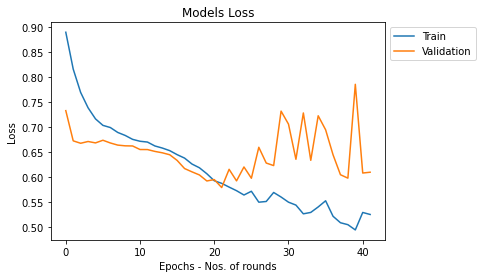

In [32]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Models Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs - Nos. of rounds')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor = (1,1))
plt.show()

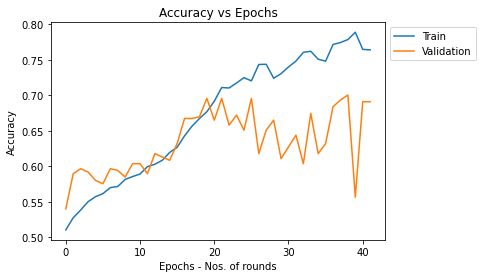

In [33]:
# Summarize history for accuracy

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs - Nos. of rounds')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor = (1,1))
plt.show()

<br>

In [34]:
model.load_weights("best_weights.hdf5")

In [35]:
# Predicting on test data 

predict = model.predict_classes(X_test)

In [36]:
# Getting accuracy score - Test Data 

from sklearn.metrics import accuracy_score
print("Accuracy_Score : {}".format(accuracy_score(predict, y_test) * 100))

Accuracy_Score : 72.88135593220339


In [37]:
from sklearn.metrics import classification_report
print("\t\t\tCLASSIFICATION REPORT:\n")
print(classification_report(y_test, predict),'\n')

print("\t\t\tCONFUSION MATRIX:\n")
print(pd.crosstab(y_test, predict.flatten(), rownames=['Actual Species'], colnames = ['Predicted Species']), '\n')

			CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       137
           1       0.67      0.69      0.68        99

    accuracy                           0.73       236
   macro avg       0.72      0.72      0.72       236
weighted avg       0.73      0.73      0.73       236
 

			CONFUSION MATRIX:

Predicted Species    0   1
Actual Species            
0                  104  33
1                   31  68 



### CONCLUSION 

    1) We applied following improvizing techniques 
     - Early Stopping 
     - Dropout Regularization
     - Batch Normalization
     - Image Augmentation
     - Model Checkpoint
     
    2) We used combination of callbacks while training our model.
      - Early Stopping   -> Monitoring the val_loss
      - Model Checkpoint -> Monitoring the val_accuracy
    
    3) Following observation were observed when best model was not used.
      - Accuracy -> 71 %
      - False Negative (FN) was 46
      - True Negative  (TN) was 53
      
    4) When we used best model via model checkpoint.
      - Accuracy -> 73 %
      - False Negative  (FN) was 31
      - True Negative   (TN) was 68
      
    5) If possible we can achieve slightly better accuracy while doing hyper parameter tuning.
      

<br>